In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from skimage.color import rgb2lab, rgb2gray
from skimage import img_as_float
from scipy.stats import skew, kurtosis


In [8]:

# Class names and their corresponding labels
class_names = ['anemic', 'Non-anemic']  
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (224, 224)


def load_data():
    """
    Load the dataset and split it into training, validation, and testing sets.
    """
    dataset_dir = r'D:\Mousa\Nile University\Grad\Mobile Application\anemia_nails_api\dataset'
    images = []
    labels = []

    print("Loading dataset...")

    for folder in class_names:
        folder_path = os.path.join(dataset_dir, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder '{folder}' does not exist in dataset directory.")
            continue
        
        label = class_names_label[folder]
        
        for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
            img_path = os.path.join(folder_path, file)
            image = cv2.imread(img_path)
            
            if image is None:
                print(f"Warning: Failed to load image {img_path}. Skipping.")
                continue
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)
            
            images.append(image)
            labels.append(label)
    
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    images, labels = shuffle(images, labels, random_state=25)
    
    # Splitting the data into 75% train, 10% validation, and 15% test
    split_1 = int(0.75 * len(images))
    split_2 = int(0.85 * len(images))
    
    train_images, train_labels = images[:split_1], labels[:split_1]
    val_images, val_labels = images[split_1:split_2], labels[split_1:split_2]
    test_images, test_labels = images[split_2:], labels[split_2:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)



In [9]:

def extract_color_features(images):
    """
    Extract color features from a list of images.
    """
    features = []

    for img in images:
        # Normalize the image (if necessary) to the range [0, 1]
        img = img_as_float(img)

        # Convert image to LAB color space
        lab = rgb2lab(img)

        # Extract L, A, B channels
        L, A, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

        # Calculate statistical moments (mean, std, skew, kurtosis) for each channel
        l_mean, l_std, l_skew, l_kurt = np.mean(L), np.std(L), skew(L.flatten()), kurtosis(L.flatten())
        a_mean, a_std, a_skew, a_kurt = np.mean(A), np.std(A), skew(A.flatten()), kurtosis(A.flatten())
        b_mean, b_std, b_skew, b_kurt = np.mean(B), np.std(B), skew(B.flatten()), kurtosis(B.flatten())

        # Histograms for each channel (normalized)
        l_hist, _ = np.histogram(L.flatten(), bins=256, range=(0, 100), density=True)
        a_hist, _ = np.histogram(A.flatten(), bins=256, range=(-128, 128), density=True)
        b_hist, _ = np.histogram(B.flatten(), bins=256, range=(-128, 128), density=True)

        # Flatten histograms and concatenate with other features
        hist_features = np.concatenate([l_hist, a_hist, b_hist])

        # Combine all extracted features into a single feature vector
        feature_vector = np.array([l_mean, l_std, l_skew, l_kurt, a_mean, a_std, a_skew, a_kurt, b_mean, b_std, b_skew, b_kurt])
        feature_vector = np.concatenate([feature_vector, hist_features])

        features.append(feature_vector)

    return np.array(features)


# Load the dataset



In [10]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data()

# Preprocess the images
train_images = preprocess_input(train_images)
val_images = preprocess_input(val_images)
test_images = preprocess_input(test_images)

# Extract color features
print("Extracting color features...")
train_features = extract_color_features(train_images)
val_features = extract_color_features(val_images)
test_features = extract_color_features(test_images)

# Dataset Statistics
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print(f"Number of training examples: {n_train}")
print(f"Number of validation examples: {n_val}")
print(f"Number of testing examples: {n_test}")
print(f"Each image is of size: {IMAGE_SIZE}")
print(f"Feature vector length: {train_features.shape[1]}")

Loading dataset...


Processing Non-anemic: 100%|██████████| 1659/1659 [00:19<00:00, 86.51it/s]


Extracting color features...


d:\Mousa\Downloads\Anaconda\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Number of training examples: 3096
Number of validation examples: 412
Number of testing examples: 620
Each image is of size: (224, 224)
Feature vector length: 780


In [11]:
import pandas as pd

# Convert the features into a pandas DataFrame to easily handle missing values
train_features_df = pd.DataFrame(train_features)

# Drop rows with any missing values
train_features = train_features_df.dropna()

# If labels also have missing values, drop them as well (ensure the feature and label arrays match)
train_labels = train_labels[train_features.index]

# Apply the same for validation and test sets
val_features_df = pd.DataFrame(val_features)
val_features = val_features_df.dropna()
val_labels = val_labels[val_features.index]

test_features_df = pd.DataFrame(test_features)
test_features = test_features_df.dropna()
test_labels = test_labels[test_features.index]

print(f"Training set size after dropping nulls: {train_features.shape[0]}")


Training set size after dropping nulls: 3033


Validation Accuracy: 99.02%
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       253
           1       1.00      0.97      0.99       154

    accuracy                           0.99       407
   macro avg       0.99      0.99      0.99       407
weighted avg       0.99      0.99      0.99       407

Test Accuracy: 98.85%
Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       376
           1       1.00      0.97      0.98       234

    accuracy                           0.99       610
   macro avg       0.99      0.99      0.99       610
weighted avg       0.99      0.99      0.99       610



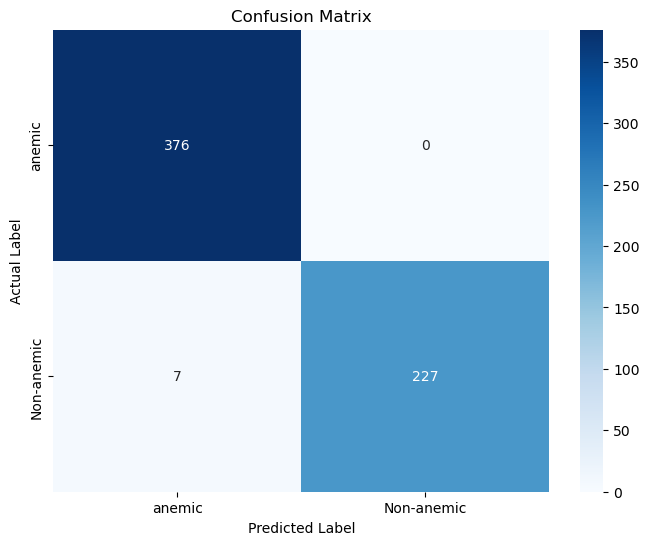

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Initialize and Train the Model
classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8)
classifier.fit(train_features, train_labels)

# Step 2: Evaluate on Validation Set
val_predictions = classifier.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)

print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))
print("Validation Classification Report:\n", classification_report(val_labels, val_predictions))

# Step 3: Evaluate on Test Set
test_predictions = classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Classification Report:\n", classification_report(test_labels, test_predictions))

# Step 4: Plot Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


In [13]:
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(classifier, train_features, train_labels, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy: {:.2f}%".format(np.mean(cv_scores) * 100))
print("Standard Deviation of CV Accuracy: {:.2f}%".format(np.std(cv_scores) * 100))


Cross-Validation Accuracy Scores: [0.98846787 0.97364086 0.99176277 0.9950495  0.99174917]
Mean Cross-Validation Accuracy: 98.81%
Standard Deviation of CV Accuracy: 0.75%


In [15]:
import joblib
# Step 1: Save the trained model
model_path = r"D:\Mousa\Nile University\Grad\Mobile Application\anemia_nails_api\artifacts\random_forest_model_nails.pkl"
joblib.dump(classifier, model_path)
print(f"Model saved at {model_path}")

Model saved at D:\Mousa\Nile University\Grad\Mobile Application\anemia_nails_api\artifacts\random_forest_model_nails.pkl


In [9]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from skimage import img_as_float
from skimage.color import rgb2lab
from scipy.stats import skew, kurtosis
from keras.applications.mobilenet_v2 import preprocess_input
import joblib

# Class names and their corresponding labels
class_names = ['anemic', 'Non-anemic']  
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (224, 224)

def extract_color_features(images):
    """
    Extract color features from a list of images.
    """
    features = []

    for img in images:
        # Normalize the image (if necessary) to the range [0, 1]
        img = img_as_float(img)

        # Convert image to LAB color space
        lab = rgb2lab(img)

        # Extract L, A, B channels
        L, A, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

        # Calculate statistical moments (mean, std, skew, kurtosis) for each channel
        l_mean, l_std, l_skew, l_kurt = np.mean(L), np.std(L), skew(L.flatten()), kurtosis(L.flatten())
        a_mean, a_std, a_skew, a_kurt = np.mean(A), np.std(A), skew(A.flatten()), kurtosis(A.flatten())
        b_mean, b_std, b_skew, b_kurt = np.mean(B), np.std(B), skew(B.flatten()), kurtosis(B.flatten())

        # Histograms for each channel (normalized)
        l_hist, _ = np.histogram(L.flatten(), bins=256, range=(0, 100), density=True)
        a_hist, _ = np.histogram(A.flatten(), bins=256, range=(-128, 128), density=True)
        b_hist, _ = np.histogram(B.flatten(), bins=256, range=(-128, 128), density=True)

        # Flatten histograms and concatenate with other features
        hist_features = np.concatenate([l_hist, a_hist, b_hist])

        # Combine all extracted features into a single feature vector
        feature_vector = np.array([l_mean, l_std, l_skew, l_kurt, a_mean, a_std, a_skew, a_kurt, b_mean, b_std, b_skew, b_kurt])
        feature_vector = np.concatenate([feature_vector, hist_features])

        features.append(feature_vector)

    return np.array(features)

def preprocess_single_image(image_path):
    """
    Preprocess a single image to prepare it for prediction.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file '{image_path}' does not exist.")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image from '{image_path}'.")

    # Convert to RGB and resize to the required input size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)

    # Normalize and preprocess the image
    image = preprocess_input(image.astype("float32"))

    # Extract color features
    features = extract_color_features([image])  # Extract features for a single image

    return features

def predict_image(image_path, model_path, class_names):
    """
    Predict the class of a single image using the loaded model.
    """
    # Load the trained model
    model = joblib.load(model_path)
    print("Model loaded successfully.")

    # Preprocess the input image and extract features
    features = preprocess_single_image(image_path)

    # Debugging: Check feature vector shape
    print(f"Extracted feature vector shape: {features.shape}")

    # Perform prediction
    prediction = model.predict(features)  # Ensure model expects shape (1, n_features)
    predicted_label = class_names[int(prediction[0])]

    return predicted_label

# Example Usage
image_path = r"D:\Mousa\Nile University\Grad\Phase 1\Nails\nails\test\Non-Anrmic-FN-009 (6).png"  # Replace with your image path
model_path = r"D:\Mousa\Nile University\Grad\Phase 1\Nails\nails\random_forest_model_nails.joblib"  # Replace with your trained model path
try:
    predicted_class = predict_image(image_path, model_path, class_names)
    print(f"The predicted class for the image is: {predicted_class}")
except Exception as e:
    print(f"Error: {e}")


Model loaded successfully.
Extracted feature vector shape: (1, 780)
The predicted class for the image is: Non-anemic


In [12]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from skimage import img_as_float
from skimage.color import rgb2lab
from scipy.stats import skew, kurtosis
from keras.applications.mobilenet_v2 import preprocess_input
import joblib

# Class names and their corresponding labels
class_names = ['anemic', 'Non-anemic']  
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (224, 224)

def extract_color_features(images):
    """
    Extract color features from a list of images.
    """
    features = []

    for img in images:
        # Normalize the image (if necessary) to the range [0, 1]
        img = img_as_float(img)

        # Convert image to LAB color space
        lab = rgb2lab(img)

        # Extract L, A, B channels
        L, A, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

        # Calculate statistical moments (mean, std, skew, kurtosis) for each channel
        l_mean, l_std, l_skew, l_kurt = np.mean(L), np.std(L), skew(L.flatten()), kurtosis(L.flatten())
        a_mean, a_std, a_skew, a_kurt = np.mean(A), np.std(A), skew(A.flatten()), kurtosis(A.flatten())
        b_mean, b_std, b_skew, b_kurt = np.mean(B), np.std(B), skew(B.flatten()), kurtosis(B.flatten())

        # Histograms for each channel (normalized)
        l_hist, _ = np.histogram(L.flatten(), bins=256, range=(0, 100), density=True)
        a_hist, _ = np.histogram(A.flatten(), bins=256, range=(-128, 128), density=True)
        b_hist, _ = np.histogram(B.flatten(), bins=256, range=(-128, 128), density=True)

        # Flatten histograms and concatenate with other features
        hist_features = np.concatenate([l_hist, a_hist, b_hist])

        # Combine all extracted features into a single feature vector
        feature_vector = np.array([l_mean, l_std, l_skew, l_kurt, a_mean, a_std, a_skew, a_kurt, b_mean, b_std, b_skew, b_kurt])
        feature_vector = np.concatenate([feature_vector, hist_features])

        features.append(feature_vector)

    return np.array(features)

def preprocess_single_image(image_path):
    """
    Preprocess a single image to prepare it for prediction.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file '{image_path}' does not exist.")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image from '{image_path}'.")

    # Convert to RGB and resize to the required input size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)

    # Normalize and preprocess the image
    image = preprocess_input(image.astype("float32"))

    # Extract color features
    features = extract_color_features([image])  # Extract features for a single image

    return features

def predict_image(image_path, model_path, class_names):
    """
    Predict the class of a single image using the loaded model.
    """
    # Load the trained model
    model = joblib.load(model_path)
    print("Model loaded successfully.")

    # Preprocess the input image and extract features
    features = preprocess_single_image(image_path)

    # Debugging: Check feature vector shape
    print(f"Extracted feature vector shape: {features.shape}")

    # Perform prediction
    prediction = model.predict(features)  # Ensure model expects shape (1, n_features)
    predicted_label = class_names[int(prediction[0])]

    return predicted_label

# Example Usage
image_path = r"D:\Mousa\Nile University\Grad\Phase 1\Nails\nails\test\Non-anemic-Fin-004 (2).png"  # Replace with your image path
model_path = r"D:\Mousa\Nile University\Grad\Phase 1\Nails\nails\random_forest_model_nails.joblib"  # Replace with your trained model path
try:
    predicted_class = predict_image(image_path, model_path, class_names)
    print(f"The predicted class for the image is: {predicted_class}")
except Exception as e:
    print(f"Error: {e}")


Model loaded successfully.
Extracted feature vector shape: (1, 780)
The predicted class for the image is: Non-anemic


In [14]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from skimage import img_as_float
from skimage.color import rgb2lab
from scipy.stats import skew, kurtosis
from keras.applications.mobilenet_v2 import preprocess_input
import joblib
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk

# Class names and their corresponding labels
class_names = ['anemic', 'Non-anemic']  
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (224, 224)

def extract_color_features(images):
    features = []
    for img in images:
        img = img_as_float(img)
        lab = rgb2lab(img)
        L, A, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

        l_mean, l_std, l_skew, l_kurt = np.mean(L), np.std(L), skew(L.flatten()), kurtosis(L.flatten())
        a_mean, a_std, a_skew, a_kurt = np.mean(A), np.std(A), skew(A.flatten()), kurtosis(A.flatten())
        b_mean, b_std, b_skew, b_kurt = np.mean(B), np.std(B), skew(B.flatten()), kurtosis(B.flatten())

        l_hist, _ = np.histogram(L.flatten(), bins=256, range=(0, 100), density=True)
        a_hist, _ = np.histogram(A.flatten(), bins=256, range=(-128, 128), density=True)
        b_hist, _ = np.histogram(B.flatten(), bins=256, range=(-128, 128), density=True)

        hist_features = np.concatenate([l_hist, a_hist, b_hist])

        feature_vector = np.array([l_mean, l_std, l_skew, l_kurt, a_mean, a_std, a_skew, a_kurt, b_mean, b_std, b_skew, b_kurt])
        feature_vector = np.concatenate([feature_vector, hist_features])

        features.append(feature_vector)

    return np.array(features)

def preprocess_single_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file '{image_path}' does not exist.")
    
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image from '{image_path}'.")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    image = preprocess_input(image.astype("float32"))

    features = extract_color_features([image])

    return features

def predict_image(image_path, model_path, class_names):
    model = joblib.load(model_path)

    features = preprocess_single_image(image_path)
    
    prediction = model.predict(features)
    predicted_label = class_names[int(prediction[0])]

    return predicted_label

def browse_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
    if file_path:
        image_label.config(text=f"Selected Image: {os.path.basename(file_path)}")
        display_image(file_path)
        result_label.config(text="")
        advice_label.config(text="")
        predict_button.config(state=tk.NORMAL, command=lambda: predict_and_display(file_path))  # Enable the predict button

def display_image(image_path):
    img = Image.open(image_path)
    img = img.resize((200, 200))
    img_tk = ImageTk.PhotoImage(img)
    image_panel.config(image=img_tk)
    image_panel.image = img_tk

def give_advice(predicted_class):
    if predicted_class == 'anemic':
        return "It is advisable to seek medical advice and consider iron-rich foods, supplements, or further medical tests."
    else:
        return "Your results indicate no anemia, but maintaining a healthy diet is still recommended."

def predict_and_display(image_path):
    model_path = r"D:\Mousa\Nile University\Grad\Phase 1\Nails\nails\random_forest_model_nails.joblib"
    try:
        predicted_class = predict_image(image_path, model_path, class_names)
        result_label.config(text=f"Predicted Class: {predicted_class}", fg="green" if predicted_class == 'Non-anemic' else "red")
        advice = give_advice(predicted_class)
        advice_label.config(text=advice, fg="blue")
    except Exception as e:
        result_label.config(text=f"Error: {str(e)}", fg="red")

# GUI setup
root = tk.Tk()
root.title("Anemia Detection using Image")
root.config(bg="#f0f0f0")

frame = tk.Frame(root, bg="#f0f0f0")
frame.pack(padx=20, pady=20)

browse_button = tk.Button(frame, text="Browse Image", command=browse_image, bg="#4CAF50", fg="white", font=("Arial", 12, "bold"))
browse_button.grid(row=0, column=0, padx=10, pady=10)

image_label = tk.Label(frame, text="No image selected", bg="#f0f0f0", font=("Arial", 10))
image_label.grid(row=1, column=0, padx=10, pady=10)

image_panel = tk.Label(frame, bg="#f0f0f0")
image_panel.grid(row=2, column=0, padx=10, pady=10)

predict_button = tk.Button(frame, text="Predict", state=tk.DISABLED, bg="#2196F3", fg="white", font=("Arial", 12, "bold"))  # Initially disabled
predict_button.grid(row=3, column=0, padx=10, pady=10)

result_label = tk.Label(frame, text="", bg="#f0f0f0", font=("Arial", 12, "bold"))
result_label.grid(row=4, column=0, padx=10, pady=10)

advice_label = tk.Label(frame, text="", bg="#f0f0f0", font=("Arial", 12, "italic"))
advice_label.grid(row=5, column=0, padx=10, pady=10)

root.mainloop()
